In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # "0,1,2,3" # "0"

In [3]:
import sys
sys.path.append(os.path.abspath('../'))
import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [4]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [5]:
!ls ../../weights/230616*F01*F08*

../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_10.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_1.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_2.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_3.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_4.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_5.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_6.w
../../weight

In [12]:
from glob import glob
debug=True
target_fbi_weight = glob("../../weights/230616*F01*F08*")
target_fbi_weight = list(filter(lambda x : "l1_on" not in x,target_fbi_weight))
for weight in target_fbi_weight:
    print(weight)    

../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_7.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_5.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_9.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_10.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_1.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_8.w
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_4.w
../../weight

In [13]:
def parsing_weight_name(fbi_weight_dir):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("x_as_")[1][:3]
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    dataset_version = 'v1' if 'with_SET01020304' in fbi_weight_dir else 'v2'
    if "l1_on_img_gradient" in fbi_weight_dir:
        lambda_val = fbi_weight_dir.split("l1_on_img_gradient_")[1].split("_")[0]
        dataset_version += f"_l1_{lambda_val}" # f"_l1_on_img_gradient_{lambda_val}
    epoch = int(fbi_weight_dir.split("_")[-1].split(".")[0])
    return target_x,target_y, dataset_version,epoch

In [14]:
import h5py
img_dict = {}
with h5py.File("../../data/test_Samsung_SNU_patches_SET050607080910_divided_by_fnum_setnum.hdf5") as f:
    for key in f.keys():
        #print(key)
        img_dict[key] = {} # f[key]
        for subkey in f[key].keys():
            img_dict[key][subkey] = np.array(f[key][subkey])
    


In [15]:
denoised_img_list = {}

noisy_images = img_dict['SET06']['F01']
for fbi_weight_dir in sorted(target_fbi_weight):
    # print(fbi_weight_dir)


    target_x,target_y, dataset_version,epoch = parsing_weight_name(fbi_weight_dir)

    # if target_y not in ['F08','F16']:
    #     continue
    print("======",target_x,"vs",target_y,dataset_version,epoch," ======")
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    model_name = f"RN2N_{target_x}-{target_y}_{dataset_version}_{epoch:02d}"

        # folder_name += "_median_filter_input_but_not_used_at_inference"
    print("model_name : ",model_name)



    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)

    img = noisy_images[0]
    img = np.expand_dims(img,axis=0)
    img = np.expand_dims(img,axis=0)
    denoised_img = model.eval(img)[0][0]
    denoised_img_list[model_name] = denoised_img

====== F01 vs F08 v2 1  ======
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_1.w
model_name :  RN2N_F01-F08_v2_01
====== F01 vs F08 v2 10  ======
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_10.w
model_name :  RN2N_F01-F08_v2_10
====== F01 vs F08 v2 2  ======
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_2.w
model_name :  RN2N_F01-F08_v2_02
====== F01 vs F08 v2 3  ======
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_3.w
model_name :  RN2N_F01-F08_v2_03
====== F01 vs F08 v2 4  ======
../../weights/230616_ensemble_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256_4.w
model_

In [16]:
denoised_img_list = sorted(denoised_img_list.items())

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float32 to uint8. Range [-0.003365673590451479, 0.9355452060699463]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.028393054381012917, 0.939929187297821]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.005635470151901245, 0.9473131895065308]. Convert image to uint8 prior to saving to suppress this warning.


RN2N_F01-F08_v2_01
RN2N_F01-F08_v2_02
RN2N_F01-F08_v2_03
RN2N_F01-F08_v2_04
RN2N_F01-F08_v2_05
RN2N_F01-F08_v2_06
RN2N_F01-F08_v2_07
RN2N_F01-F08_v2_08
RN2N_F01-F08_v2_09
RN2N_F01-F08_v2_10


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


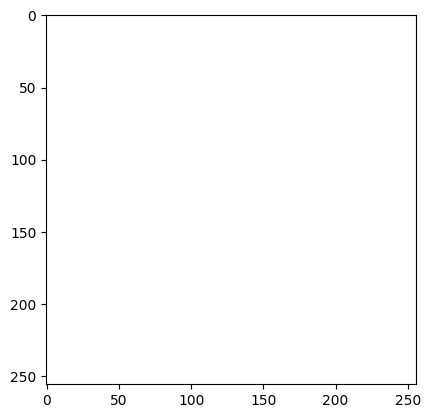

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [17]:
from celluloid import Camera # getting the camera
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
frames = []
fig, ax = plt.subplots() # make it bigger
camera = Camera(fig)# the camera gets our figure
for key, img in denoised_img_list:
    plt.figure(figsize=(10,10))
    print(key)
    # ax.title(key)
    ax.imshow(img,cmap='gray')
    frames.append(img)
    camera.snap()
# ax.imshow(epoch10,cmap='gray')
# camera.snap()
animation = camera.animate()
imageio.mimsave("./F01-F08_SET06_F01.gif", frames, fps=2.5)
HTML(animation.to_html5_video())

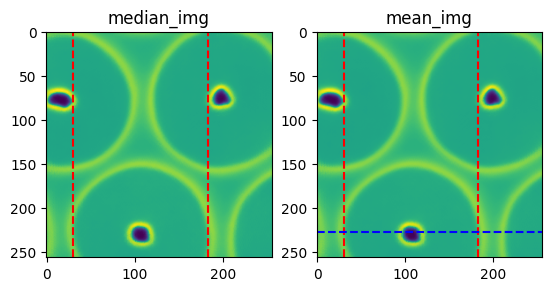

In [46]:
median_img = np.median(frames,axis=0)
plt.subplot(121)
plt.title("median_img")
plt.imshow(median_img)
plt.axvline(x=30, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
plt.subplot(122)
# epoch = 9
# plt.title("epoch : "+str(epoch))
# plt.imshow(frames[epoch-1]) 
mean_img = np.mean(frames,axis=0)
plt.title("mean_img")
plt.imshow(mean_img)
plt.axvline(x=30, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
# plt.axvline(x=185, color='b', linestyle='--')
plt.axhline(y=227, color='b', linestyle='--')

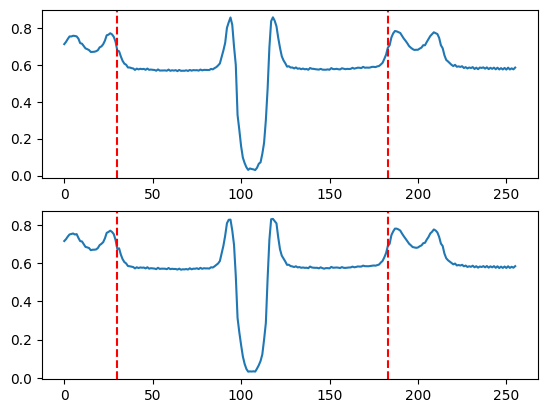

In [47]:
axis = 227
plt.subplot(211)
plt.plot(median_img[axis])

plt.axvline(x=30, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
plt.subplot(212)
plt.plot(mean_img[axis])

plt.axvline(x=30, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')

In [49]:
# https://wandb.ai/hwbae0326/RN2N_variation_CV/runs/h4lu29bq/logs?workspace=user-hwbae0326
# set6을 제외하고 나머지를 training set으로 한 모델
epoch9 = cv2.imread("./media_images_eval_F01-F04_SET06_F01_epoch9.png", cv2.IMREAD_GRAYSCALE)
epoch10 = cv2.imread("./media_images_eval_F01-F04_SET06_F01_epoch10.png",cv2.IMREAD_GRAYSCALE)

Text(170, 50, '')

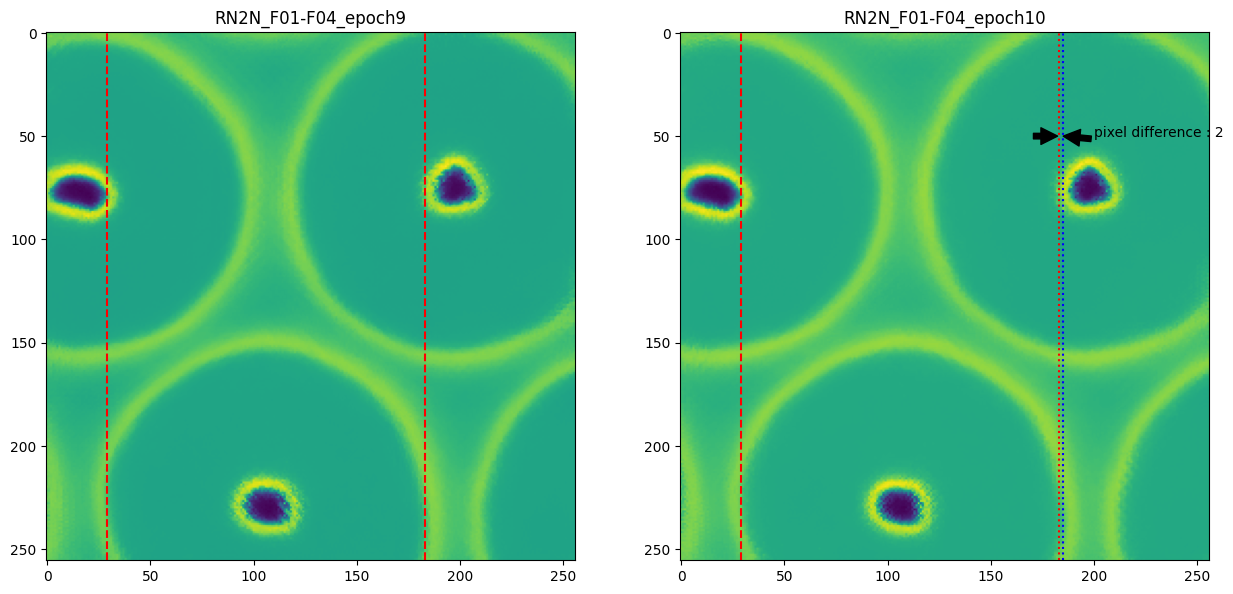

In [55]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title("RN2N_F01-F04_epoch9")
plt.imshow(epoch9)
plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
plt.subplot(122)
plt.title("RN2N_F01-F04_epoch10")
plt.imshow(epoch10)
plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle=':')
plt.axvline(x=185, color='b', linestyle=':')

plt.annotate('pixel difference : 2', xy=(185, 50), xytext=(200, 50), color='black', fontsize=10,
             arrowprops=dict(facecolor='black', shrink=0.005))

plt.annotate('', xy=(183, 50), xytext=(170, 50), color='black', fontsize=10,
             arrowprops=dict(facecolor='black', shrink=0.05))

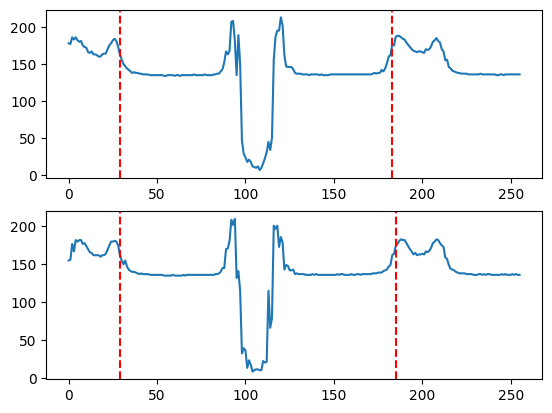

In [58]:
axis = 227
plt.subplot(211)
plt.plot(epoch9[axis])

plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
plt.subplot(212)
plt.plot(epoch10[axis])

plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=185, color='r', linestyle='--')